In [1]:
import torch
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
# from utils import displayMathHelper
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19
from IPython.display import display, Math

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 400

vgg_model = vgg19(pretrained = True).to(device).eval()

In [3]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Computing Content Cost

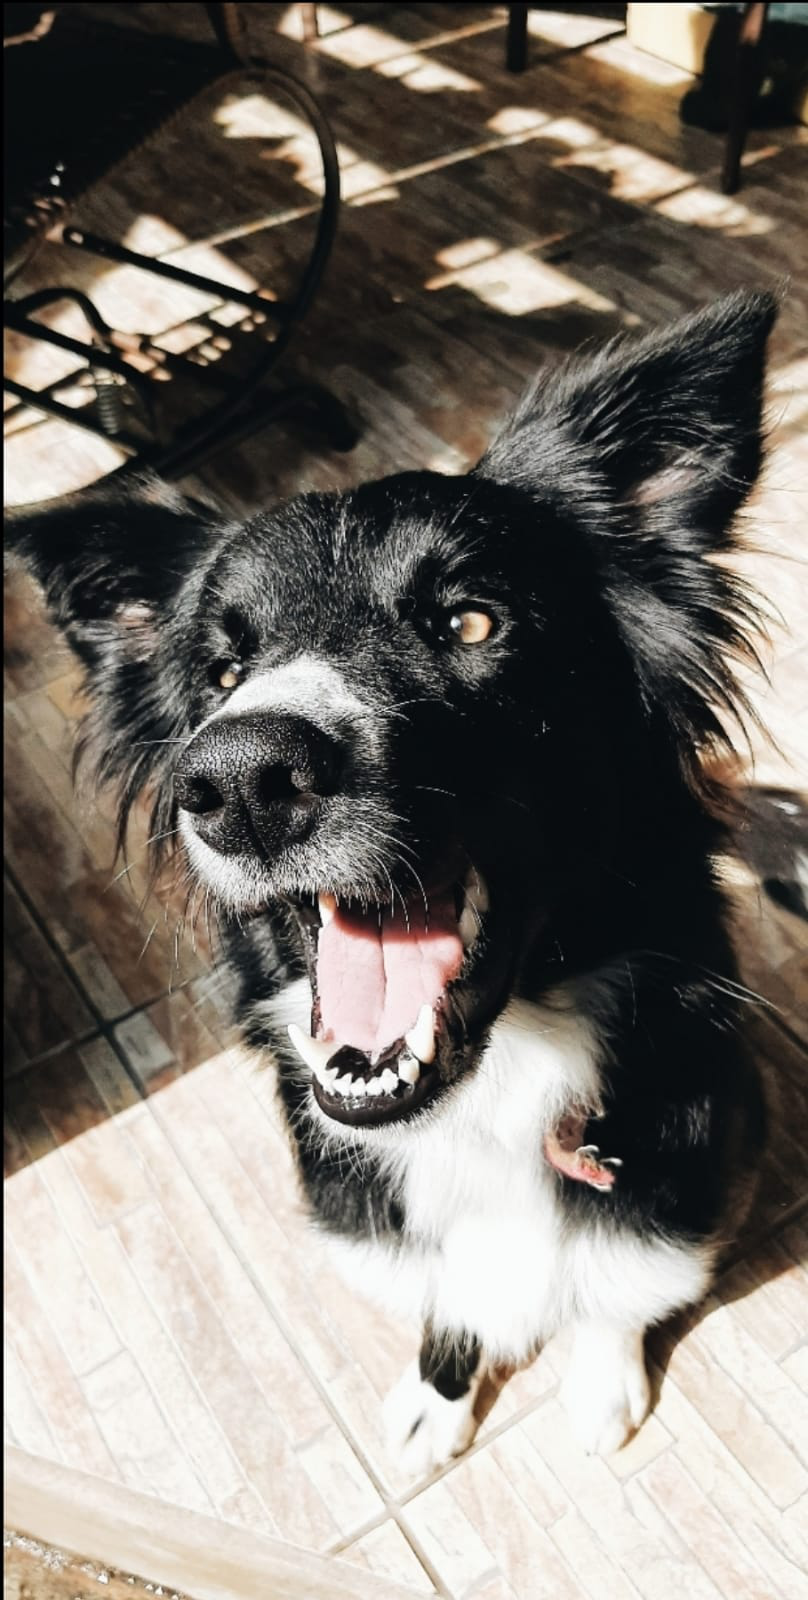

In [4]:
content_img = Image.open('./data/nst_pics/kira.jpg')

content_img

In [5]:
def computeContentCost(content_model_out, generated_model_out):
    """
    
    """

    # Take activation of the last Conv Layer
    a_C = content_model_out[-1]
    a_G = generated_model_out[-1]

    # Retrieve dimensions to unroll the activations
    # volumes into a 2D matrix
    _, n_C, n_H, n_W  = a_C.shape
    a_C_unrolled = torch.reshape(a_C , (n_C, -1))
    a_G_unrolled = torch.reshape(a_G , (n_C, -1))

    # Compute content loss
    J_c = torch.sum(torch.square(torch.subtract(a_C_unrolled, a_G_unrolled))) / (4 * n_C * n_H * n_W)

    return J_c

In [6]:
torch.random.manual_seed(1)

a_C = torch.normal(mean=1, std=4, size=(1, 1, 4, 4, 3))
a_G = torch.normal(mean=1, std=4, size=(1, 1, 4, 4, 3))

J_content = computeContentCost(a_C, a_G)

print(J_content)

tensor(8.4785)


## Computing Style Layer Cost

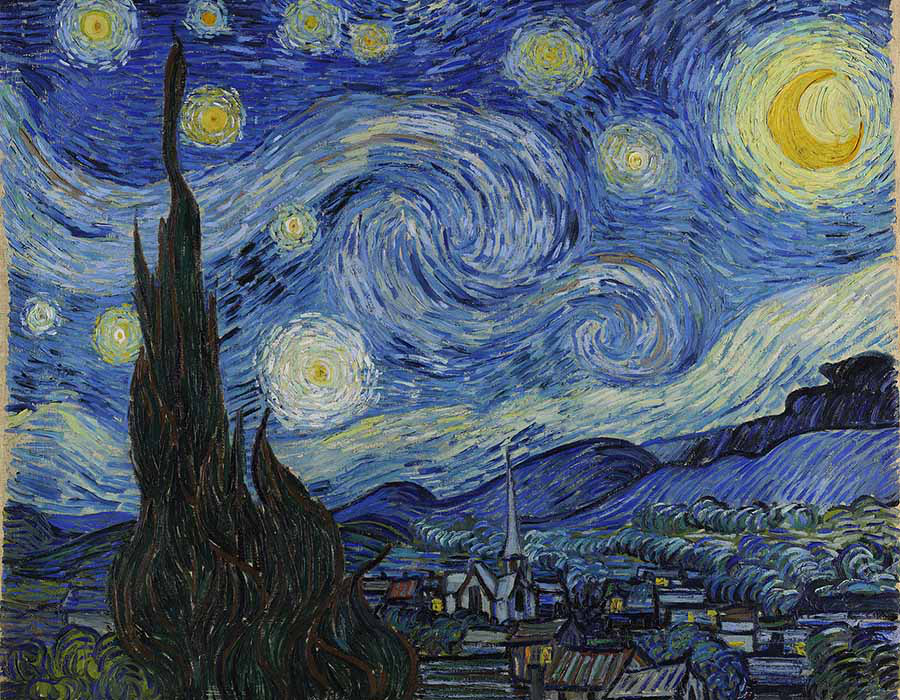

In [7]:
style_img = Image.open('./data/nst_pics/noite_estrelada.jpg')

style_img

In [8]:
def GramMatrix(A):
    G = torch.matmul(A, torch.transpose(A, 0, 1))

    return G

def computeStyleLayerCost(style_layer_model_out, generated_layer_model_out):
    """
    
    """

    # Take activation of the selected layer
    a_S = style_layer_model_out
    a_G = generated_layer_model_out

    # Retrieve dimensions to unroll the activations
    # volumes into a 2D matrix
    _, n_C, n_H, n_W  = a_S.shape
    a_S_unrolled = torch.reshape(a_S , (n_C, -1))
    a_G_unrolled = torch.reshape(a_G , (n_C, -1))

    # Compute the cross-correlation matrix G (Gram Matrix)
    G_S = GramMatrix(a_S_unrolled)
    G_G = GramMatrix(a_G_unrolled)

    # Compute content loss
    J_s_layer = torch.sum(torch.square(torch.subtract(G_S, G_G))) / ((2 * n_C * n_H * n_W)**2)

    return J_s_layer

In [9]:
torch.random.manual_seed(1)

a_S = torch.normal(mean=1, std=4, size=(1, 4, 4, 3))
a_G = torch.normal(mean=1, std=4, size=(1, 4, 4, 3))

J_style_layer = computeStyleLayerCost(a_S, a_G)

print(J_style_layer)

tensor(9.0995)


## Computing Style Cost

In [10]:
def computeStyleCost(style_model_out, generated_model_out, style_layers):
    """
    
    """

    J_s = 0

    # The last selected layer activation is only
    # used in the content cost, so it's discarded here
    a_S = style_model_out[:-1]
    a_G = generated_model_out[:-1]

    for i, layer in zip(range(len(a_S)), style_layers):
        J_s_layer = computeStyleLayerCost(a_S[i], a_G[i])

        J_s += layer[1]*J_s_layer

    return J_s

## Computing Total Cost

In [11]:
def computeTotalCost(J_content, J_style, alpha=10, beta=40):
    """
    
    """
    J_total = alpha*J_content + beta*J_style

    return J_total

## Putting all together

torch.Size([1, 400, 400, 3])


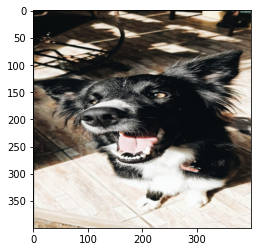

torch.Size([1, 3, 400, 400])


In [12]:
content_img = np.array(Image.open("data/nst_pics/kira.jpg").resize((img_size, img_size)))
content_img = torch.tensor(np.reshape(content_img, ((1,) + content_img.shape)))

print(content_img.shape)
imshow(content_img[0])
plt.show()

content_img = torch.permute(content_img, (0, 3, 1, 2)) / 255.
content_img = content_img.to(device)
print(content_img.shape)

torch.Size([1, 400, 400, 3])


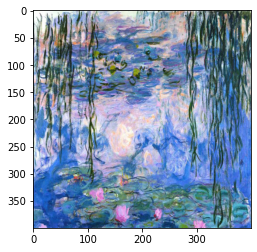

torch.Size([1, 3, 400, 400])


In [13]:
style_img = np.array(Image.open("data/nst_pics/nenufares.jpg").resize((img_size, img_size)))
style_img = torch.tensor(np.reshape(style_img, ((1,) + style_img.shape)))

print(style_img.shape)
imshow(style_img[0])
plt.show()

style_img = torch.permute(style_img, (0, 3, 1, 2)) / 255.
style_img = style_img.to(device).requires_grad_(False)
print(style_img.shape)

torch.Size([1, 400, 400, 3])


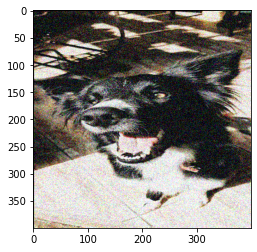

torch.Size([1, 3, 400, 400])


In [14]:
generated_image_path = "data/nst_pics/kira.jpg"

generated_img = np.array(Image.open(generated_image_path).resize((img_size, img_size)))
g_n_H, g_n_W = np.array(Image.open(generated_image_path)).shape[:2]
generated_img = torch.tensor(np.reshape(generated_img, ((1,) + generated_img.shape))) / 255.
noise = torch.distributions.uniform.Uniform(-0.25, 0.25).sample(generated_img.shape)
generated_img = torch.add(generated_img, noise)
generated_img = torch.clip(generated_img, min=0.0, max=1.0)

print(generated_img.shape)
imshow(generated_img[0])
plt.show()

generated_img = torch.permute(generated_img, (0, 3, 1, 2)).to(device).requires_grad_(True)
print(generated_img.shape)

In [15]:
def getActivation(layer):
    def hook(model, input, output):
        activation[layer] = output
    return hook

def setLayerOutputHook(model, layers):
    for layer in layers:
        model.features[layer[0]].register_forward_hook(getActivation(layer[0]))    

In [16]:
style_layers = [
    (0, 0.2),  # block1_conv1
    (5, 0.2),  # block2_conv1
    (10, 0.2), # block3_conv1
    (19, 0.2), # block4_conv1
    (28, 0.2)  # block5_conv1
]

content_layer = [
    (34, 1)   # block5_conv4
]

setLayerOutputHook(vgg_model, style_layers + content_layer)

In [17]:
activation = {}
_ = vgg_model(content_img)
a_C = [act.detach() for act in list(activation.values())]

activation = {}
_ = vgg_model(style_img)
a_S = [act.detach() for act in list(activation.values())]

In [18]:
def trainStep(generated_image):
    _ = vgg_model(generated_image)
    a_G = list(activation.values())

    # Compute style cost
    J_style = computeStyleCost(a_S, a_G, style_layers)

    # Compute content cost
    J_content = computeContentCost(a_C, a_G)

    # Compute total cost
    J = computeTotalCost(J_content, J_style, 8, 80)

    # Backward pass
    J.backward()

    # Update parameters
    optimizer.step()

    # Zero grad
    optimizer.zero_grad()

In [ ]:
optimizer = torch.optim.Adam([generated_img], lr=0.001)

epochs = 20001
for epoch in range(epochs):
    activation = {}
    trainStep(generated_img)
    if epoch % 2000 == 0:
        print(f"Epoch {epoch} ")
    if epoch % 2000 == 0:
        image = torchvision.transforms.ToPILImage()(
            torch.clip(generated_img[0], min=0.0, max=1.0)
        ).resize((g_n_W, g_n_H))
        imshow(image)
        image.save(f"./data/nst_pics/outputs/image_{int(epoch/2000)+1}.jpg")
        plt.show() 